## Imports

In [16]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import SGDClassifier

%cd src
from visualizations import plot_linear_classification_coefs
from visualizations import plot_learning_curve
from visualizations import plot_confusion_matrix
%cd ..

common_signals = [
    "EEG Fpz-Cz",
    "EEG Pz-Oz",
    "EOG horizontal",  # All have the same sampling rate (100 Hz)
    "EMG submental",  # Different sampling rate: 100 Hz for telemetry & 1 Hz for cassette
]

c:\Users\ahmat\Documents\_ITBA\5to\1er Cuatrimestre\Neuro\sleep-linear\src
c:\Users\ahmat\Documents\_ITBA\5to\1er Cuatrimestre\Neuro\sleep-linear


## Sleep Cassette Features

In [17]:
dfs = []
data_folder = "./data"
sub_folder = "/sleep-cassette"
sorted_files = sorted(os.listdir(data_folder + sub_folder))
psg_hypnogram_files = [(p, h) for p, h in zip(sorted_files[::2], sorted_files[1:][::2])]
df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
df_files["subfolder"] = sub_folder

# Because for the SC study patients were monitored for 2 consecutive nights
df_files["patient_id"] = df_files.psg_file.apply(lambda f: f[:5])
paper_patients = ["SC400", "SC401","SC402","SC403","SC404","SC405", "SC406", "SC407","SC408","SC409"]
df_files_paper = df_files[df_files.patient_id.isin(paper_patients)]

In [18]:
df_cassette_feats = pd.read_parquet("./features/sleep-edf_cassette_features.parquet")

eeg_signals = [d for d in common_signals if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [
        c
        for c in df_cassette_feats.columns
        if c.startswith(eeg_sig) and c.split("__")[1] in bands
    ]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = (
            df_cassette_feats["__".join([eeg_sig, "sdelta", window])]
            + df_cassette_feats["__".join([eeg_sig, "fdelta", window])]
        )
        fdelta_theta = (
            df_cassette_feats["__".join([eeg_sig, "fdelta", window])]
            + df_cassette_feats["__".join([eeg_sig, "theta", window])]
        )
        alpha = df_cassette_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_cassette_feats["__".join([eeg_sig, "beta", window])]
        theta = df_cassette_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_cassette_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_cassette_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")
        df_cassette_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_cassette_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_cassette_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_cassette_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")

skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_cassette_feats.columns if c not in skip_cols]
pattern = re.compile(r'w=1m(?!\d)')

# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_cassette_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_cassette_feats.columns if pattern.search(f)]
feats_90s = [f for f in df_cassette_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_cassette_feats.psg_file.unique():
    sub_df = df_cassette_feats[df_cassette_feats.psg_file == psg_file]

    sub_df = sub_df.merge( sub_df[feats_90s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(sub_df[feats_60s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge( sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"),left_index=True, right_index=True)
    dfs += [sub_df]

df_cassette_feats = pd.concat(dfs)
df_cassette_feats.shape

(273558, 366)

In [21]:
df_cassette_feats.loc[df_cassette_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_cassette_feats = df_cassette_feats[df_cassette_feats["label"] != "Movement time"]
df_cassette_feats = df_cassette_feats[df_cassette_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_cassette_feats_paper = df_cassette_feats[df_cassette_feats.psg_file.isin(df_files_paper.psg_file)]
df_cassette_feats_paper.shape

(54479, 1051)

In [22]:
def get_repeat_length(val, arr):
    assert arr[0] == val
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_cassette_feats_paper["psg_file"].unique():
    sub_df = df_cassette_feats[df_cassette_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_cassette_feats_trimmed_paper = pd.concat(dfs)
del dfs

In [23]:
def get_repeat_length(val, arr):
    if arr[0] != val:
        return 0
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_cassette_feats["psg_file"].unique():
    sub_df = df_cassette_feats[df_cassette_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_cassette_feats_trimmed_all = pd.concat(dfs)
del dfs

## ML Model

In [24]:
# Subset of data that does not contain the SC-EDF-10 patients
df_cassette_feats_trimmed = df_cassette_feats_trimmed_all[~df_cassette_feats_trimmed_all.psg_file.isin(df_cassette_feats_trimmed_paper.psg_file.unique())]
df_cassette_feats_trimmed.shape

(95216, 1051)

In [27]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model",
            SGDClassifier(
                loss="log_loss",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

In [28]:
print(df_cassette_feats_trimmed.columns.tolist())
print(feat_cols)
missing_cols = [col for col in feat_cols if col not in df_cassette_feats_trimmed.columns]
len(missing_cols)
if missing_cols:
    feat_cols = [col for col in feat_cols if col in df_cassette_feats_trimmed.columns]
    print("Updated feature columns:", feat_cols)

['EEG Fpz-Cz__TotalAbsPow__w=1m', 'EEG Fpz-Cz__TotalAbsPow__w=30s', 'EEG Fpz-Cz__alpha__w=1m', 'EEG Fpz-Cz__alpha__w=30s', 'EEG Fpz-Cz__beta__w=1m', 'EEG Fpz-Cz__beta__w=30s', "EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m", "EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=30s", "EEG Fpz-Cz__binned_entropy_{'max_bins': 30}__w=1m", "EEG Fpz-Cz__binned_entropy_{'max_bins': 30}__w=30s", "EEG Fpz-Cz__binned_entropy_{'max_bins': 5}__w=1m", "EEG Fpz-Cz__binned_entropy_{'max_bins': 5}__w=30s", "EEG Fpz-Cz__binned_entropy_{'max_bins': 60}__w=1m", "EEG Fpz-Cz__binned_entropy_{'max_bins': 60}__w=30s", 'EEG Fpz-Cz__fdelta__w=1m', 'EEG Fpz-Cz__fdelta__w=30s', "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'centroid'}__w=1m", "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'centroid'}__w=30s", "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'kurtosis'}__w=1m", "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'kurtosis'}__w=30s", "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'skew'}__w=1m", "EEG Fpz-Cz__fft_aggregated_{'aggtype': 'sk

In [29]:
### Fit the pipeline
pipe.fit(df_cassette_feats_trimmed[feat_cols], df_cassette_feats_trimmed["label"])

Pipeline(steps=[('impute', SimpleImputer()),
                ('scale',
                 QuantileTransformer(n_quantiles=100, random_state=0,
                                     subsample=200000)),
                ('linear_model',
                 SGDClassifier(average=True, class_weight='balanced',
                               loss='log_loss', n_jobs=5, random_state=0))])

In [30]:
print("Training data:")
preds = pipe.predict(df_cassette_feats_trimmed[feat_cols])
preds_proba = pipe.predict_proba(df_cassette_feats_trimmed[feat_cols])
print("Log loss:", log_loss(y_true=df_cassette_feats_trimmed["label"], y_pred=preds_proba))
print(classification_report(y_true=df_cassette_feats_trimmed["label"], y_pred=preds))

Training data:
Log loss: 0.4854333029189249
               precision    recall  f1-score   support

Sleep stage 1       0.48      0.47      0.48      9440
Sleep stage 2       0.87      0.83      0.85     36089
Sleep stage 3       0.73      0.89      0.80      7301
Sleep stage R       0.81      0.85      0.83     13792
Sleep stage W       0.93      0.91      0.92     28594

     accuracy                           0.83     95216
    macro avg       0.77      0.79      0.78     95216
 weighted avg       0.83      0.83      0.83     95216



In [31]:
print("Testing data:")
preds = pipe.predict(df_cassette_feats_trimmed_paper[feat_cols])
preds_proba = pipe.predict_proba(df_cassette_feats_trimmed_paper[feat_cols])
print("Log loss:", log_loss(y_true=df_cassette_feats_trimmed_paper["label"], y_pred=preds_proba))
print(classification_report(y_true=df_cassette_feats_trimmed_paper["label"], y_pred=preds))

Testing data:
Log loss: 0.4385168937448232
               precision    recall  f1-score   support

Sleep stage 1       0.56      0.37      0.44      1689
Sleep stage 2       0.92      0.85      0.88      8927
Sleep stage 3       0.83      0.94      0.88      3074
Sleep stage R       0.78      0.91      0.84      3693
Sleep stage W       0.89      0.94      0.92      3617

     accuracy                           0.85     21000
    macro avg       0.80      0.80      0.79     21000
 weighted avg       0.85      0.85      0.84     21000



In [32]:
print("F1 macro: ", f1_score(preds, df_cassette_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_cassette_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_cassette_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_cassette_feats_trimmed_paper["label"], y_pred=preds_proba))
print("Acc:      ", accuracy_score(preds, df_cassette_feats_trimmed_paper["label"]))

F1 macro:  0.7924339866371551
Bal. Acc:  0.7951192127963796
Kappa:     0.7970313829773988
Log loss : 0.4385168937448232
Acc:       0.8504761904761905


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

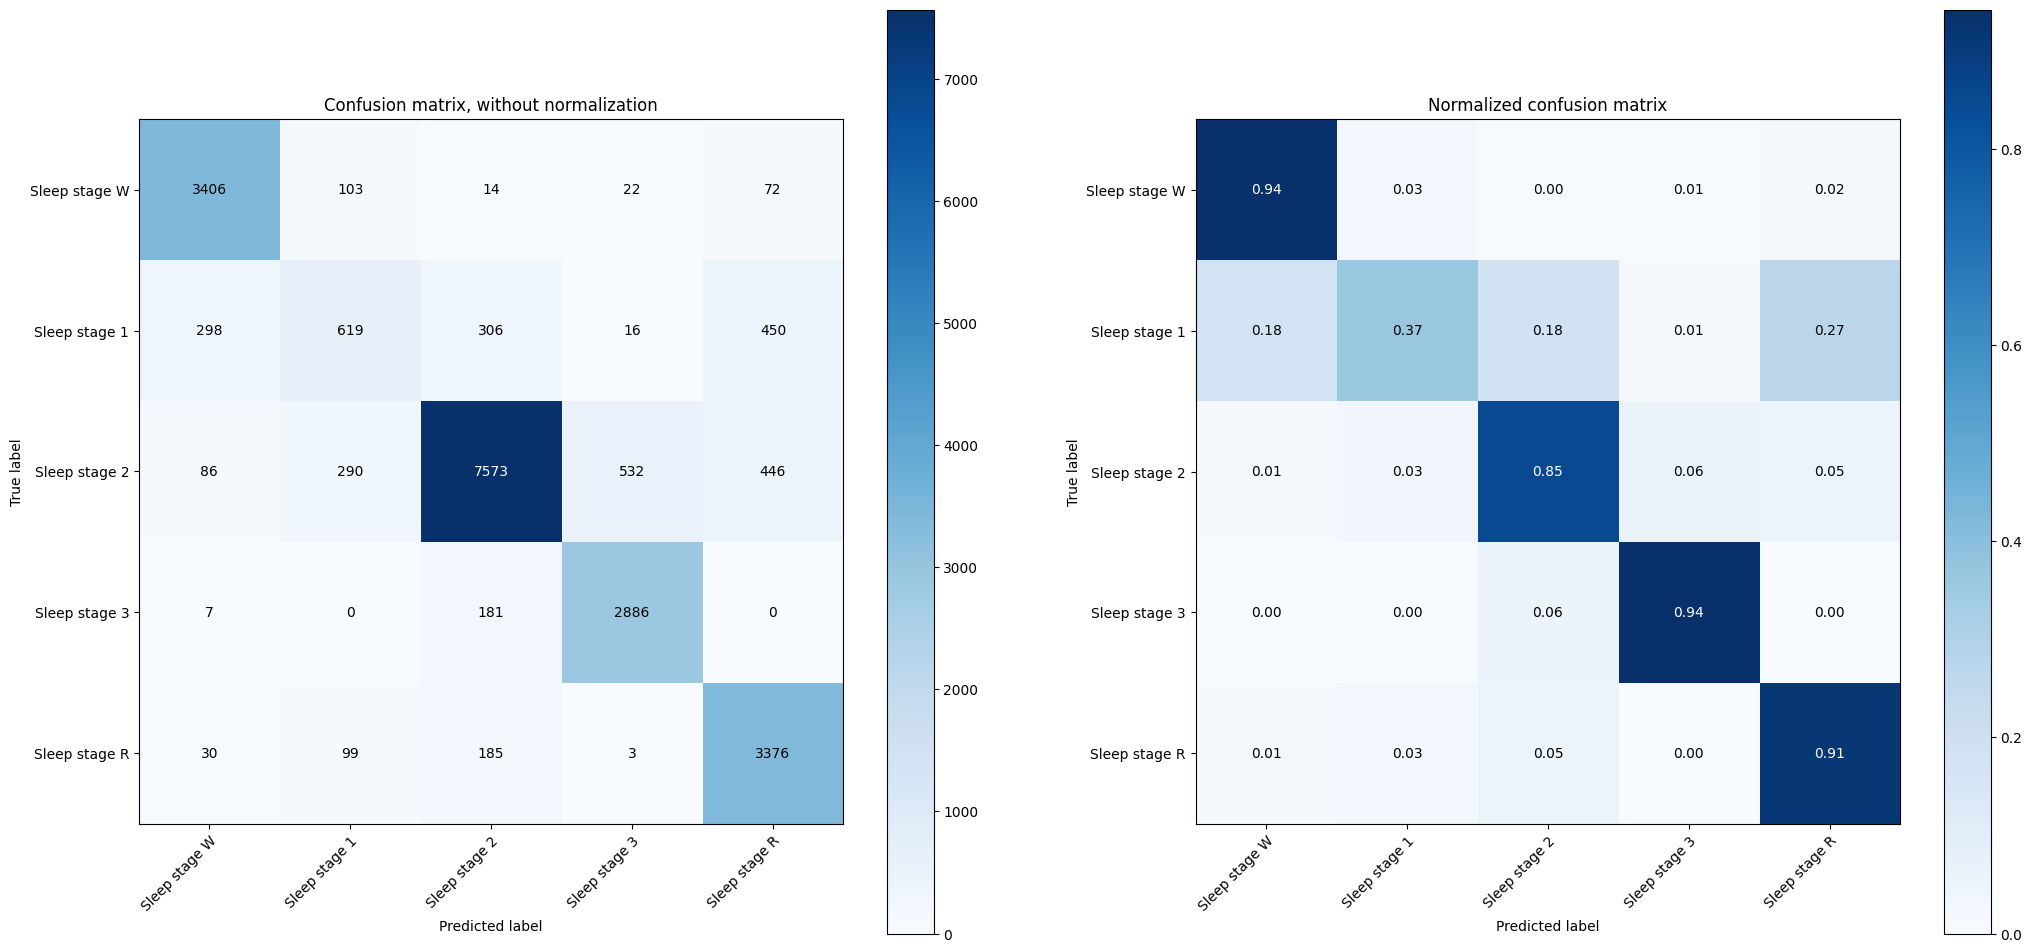

In [33]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_cassette_feats_trimmed_paper["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_cassette_feats_trimmed_paper["label"], classes=classes, normalize=True, ax=ax)

## Sleep Telemetry Features

In [64]:
dfs = []
data_folder = "./data"
sub_folder = "/sleep-telemetry"
sorted_files = sorted(os.listdir(data_folder + sub_folder))
psg_hypnogram_files = [(p, h) for p, h in zip(sorted_files[::2], sorted_files[1:][::2])]
df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
df_files["subfolder"] = sub_folder

df_files["patient_id"] = df_files.psg_file.apply(lambda f: f[:5])
# Because for the ST study patients were monitored for 2 consecutive nights (one with placebo and one with temazepam)
df_night_1 = df_files[df_files['psg_file'].str.contains('1J')]
df_night_2 = df_files[df_files['psg_file'].str.contains('2J')]

In [67]:
df_telemetry_feats = pd.read_parquet("./features/sleep-edf_telemetry_features.parquet")

eeg_signals = [d for d in common_signals if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [
        c
        for c in df_telemetry_feats.columns
        if c.startswith(eeg_sig) and c.split("__")[1] in bands
    ]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = (df_telemetry_feats["__".join([eeg_sig, "sdelta", window])] + df_telemetry_feats["__".join([eeg_sig, "fdelta", window])])
        fdelta_theta = (df_telemetry_feats["__".join([eeg_sig, "fdelta", window])] + df_telemetry_feats["__".join([eeg_sig, "theta", window])])
        alpha = df_telemetry_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_telemetry_feats["__".join([eeg_sig, "beta", window])]
        theta = df_telemetry_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_telemetry_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_telemetry_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")
        df_telemetry_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_telemetry_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_telemetry_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_telemetry_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")

skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_telemetry_feats.columns if c not in skip_cols]
pattern = re.compile(r'w=1m(?!\d)')

# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_telemetry_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_telemetry_feats.columns if pattern.search(f)]
feats_90s = [f for f in df_telemetry_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_telemetry_feats.psg_file.unique():
    sub_df = df_telemetry_feats[df_telemetry_feats.psg_file == psg_file]

    sub_df = sub_df.merge(sub_df[feats_90s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(sub_df[feats_60s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]

df_telemetry_feats = pd.concat(dfs)

# Postprocess labels
df_telemetry_feats.loc[df_telemetry_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_telemetry_feats = df_telemetry_feats[df_telemetry_feats["label"] != "Movement time"]
df_telemetry_feats = df_telemetry_feats[df_telemetry_feats["label"] != "Sleep stage ?"]

df_telemetry_feats.shape

131 131 131


(42756, 1051)

### Placebo Nights Data

In [56]:
placebo_patients_night_1 = ["ST701", "ST704", "ST706", "ST707", "ST710", "ST712", "ST714", "ST715", "ST717", "ST720", "ST722", "ST724"]
df_placebo_patients_1 = df_night_1[df_night_1.patient_id.isin(placebo_patients_night_1)]
df_placebo_patients_2 = df_night_2[~df_night_2.patient_id.isin(placebo_patients_night_1)]
df_placebo_patients = pd.concat([df_placebo_patients_1, df_placebo_patients_2])
df_placebo_patients.shape

(22, 4)

### Temazepam Nights Data

In [57]:
temazepam_patients_night_1 = ["ST702", "ST705", "ST708", "ST709", "ST711", "ST713", "ST716", "ST718", "ST719", "ST721"]
df_temazepam_patients_1 = df_night_1[df_night_1.patient_id.isin(temazepam_patients_night_1)]
df_temazepam_patients_2 = df_night_2[~df_night_2.patient_id.isin(temazepam_patients_night_1)]
df_temazepam_patients = pd.concat([df_temazepam_patients_1, df_temazepam_patients_2])
df_temazepam_patients.shape

(22, 4)

### Placebo Nights ML Evaluation

Sleep Telemetry for placebo patients:
Log loss: 0.6872529128119828
               precision    recall  f1-score   support

Sleep stage 1       0.46      0.40      0.42      1609
Sleep stage 2       0.85      0.90      0.87     10358
Sleep stage 3       0.86      0.86      0.86      3270
Sleep stage R       0.87      0.71      0.78      4218
Sleep stage W       0.71      0.86      0.78      1987

     accuracy                           0.81     21442
    macro avg       0.75      0.74      0.74     21442
 weighted avg       0.81      0.81      0.81     21442



======================= Metrics =======================
F1 macro:  0.743118024256208
Bal. Acc:  0.749245480964266
Kappa:     0.7274838360471725
Log loss : 0.6872529128119828
Acc:       0.8137300624941703


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

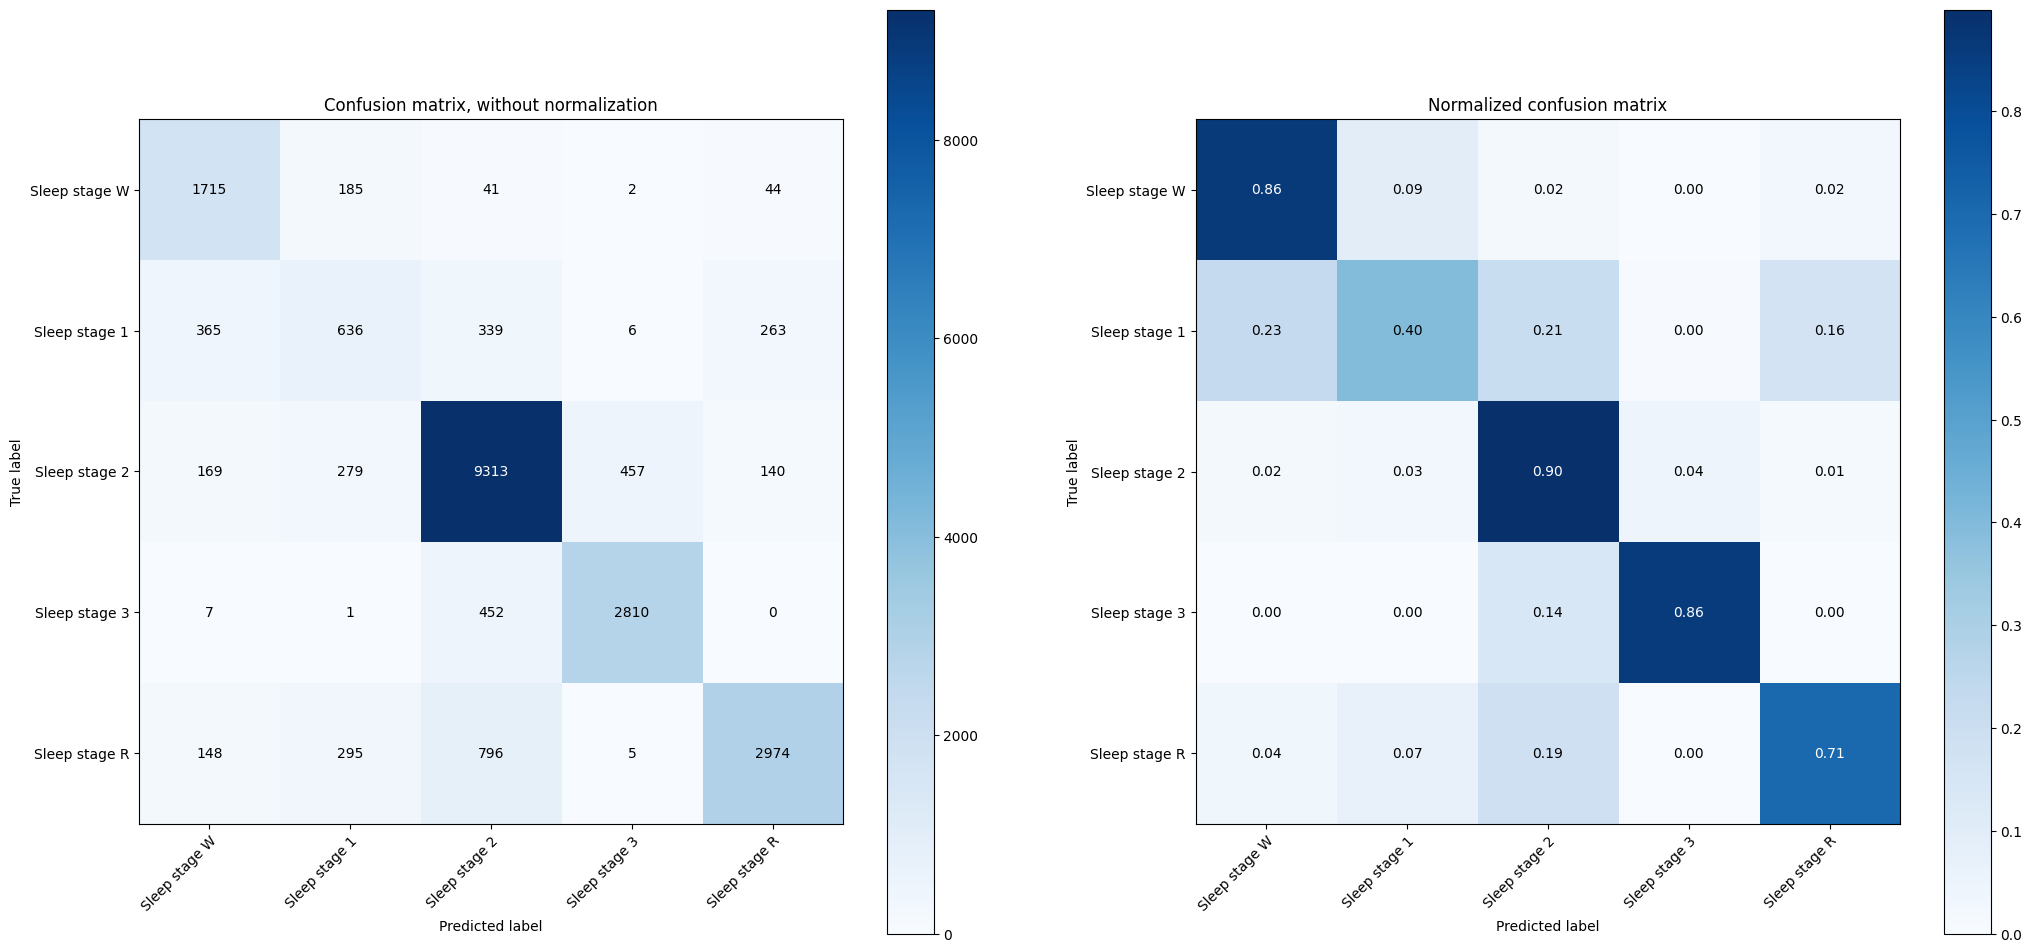

In [72]:
df_telemetry_placebo_feats = df_telemetry_feats[~df_telemetry_feats.psg_file.isin(df_placebo_patients.psg_file.unique())]

missing_cols = [col for col in feat_cols if col not in df_telemetry_placebo_feats.columns]
if missing_cols:
    feat_cols = [col for col in feat_cols if col in df_telemetry_placebo_feats.columns]

# Predict on placebo patients
print("Sleep Telemetry for placebo patients:")
preds = pipe.predict(df_telemetry_placebo_feats[feat_cols])
preds_proba = pipe.predict_proba(df_telemetry_placebo_feats[feat_cols])
print("Log loss:", log_loss(y_true=df_telemetry_placebo_feats["label"], y_pred=preds_proba))
print(classification_report(y_true=df_telemetry_placebo_feats["label"], y_pred=preds))

# Metrics
print("\n\n======================= Metrics =======================")
print("F1 macro: ", f1_score(preds, df_telemetry_placebo_feats["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_telemetry_placebo_feats["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_telemetry_placebo_feats["label"]))
print("Log loss :", log_loss(y_true=df_telemetry_placebo_feats["label"], y_pred=preds_proba))
print("Acc:      ", accuracy_score(preds, df_telemetry_placebo_feats["label"]))
print("=======================================================")

# Confusion matrix
classes = ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R']
plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_telemetry_placebo_feats["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_telemetry_placebo_feats["label"], classes=classes, normalize=True, ax=ax)

### Temazepam Nights ML Evaluation

Sleep Telemetry for placebo patients:
Log loss: 0.7300663016451411
               precision    recall  f1-score   support

Sleep stage 1       0.52      0.35      0.42      2044
Sleep stage 2       0.84      0.86      0.85      9493
Sleep stage 3       0.76      0.80      0.78      3145
Sleep stage R       0.85      0.82      0.83      4131
Sleep stage W       0.73      0.83      0.78      2501

     accuracy                           0.79     21314
    macro avg       0.74      0.73      0.73     21314
 weighted avg       0.78      0.79      0.79     21314



======================= Metrics =======================
F1 macro:  0.7314398576950174
Bal. Acc:  0.7376627499085859
Kappa:     0.7085385625645102
Log loss : 0.7300663016451411
Acc:       0.7915454630759126


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

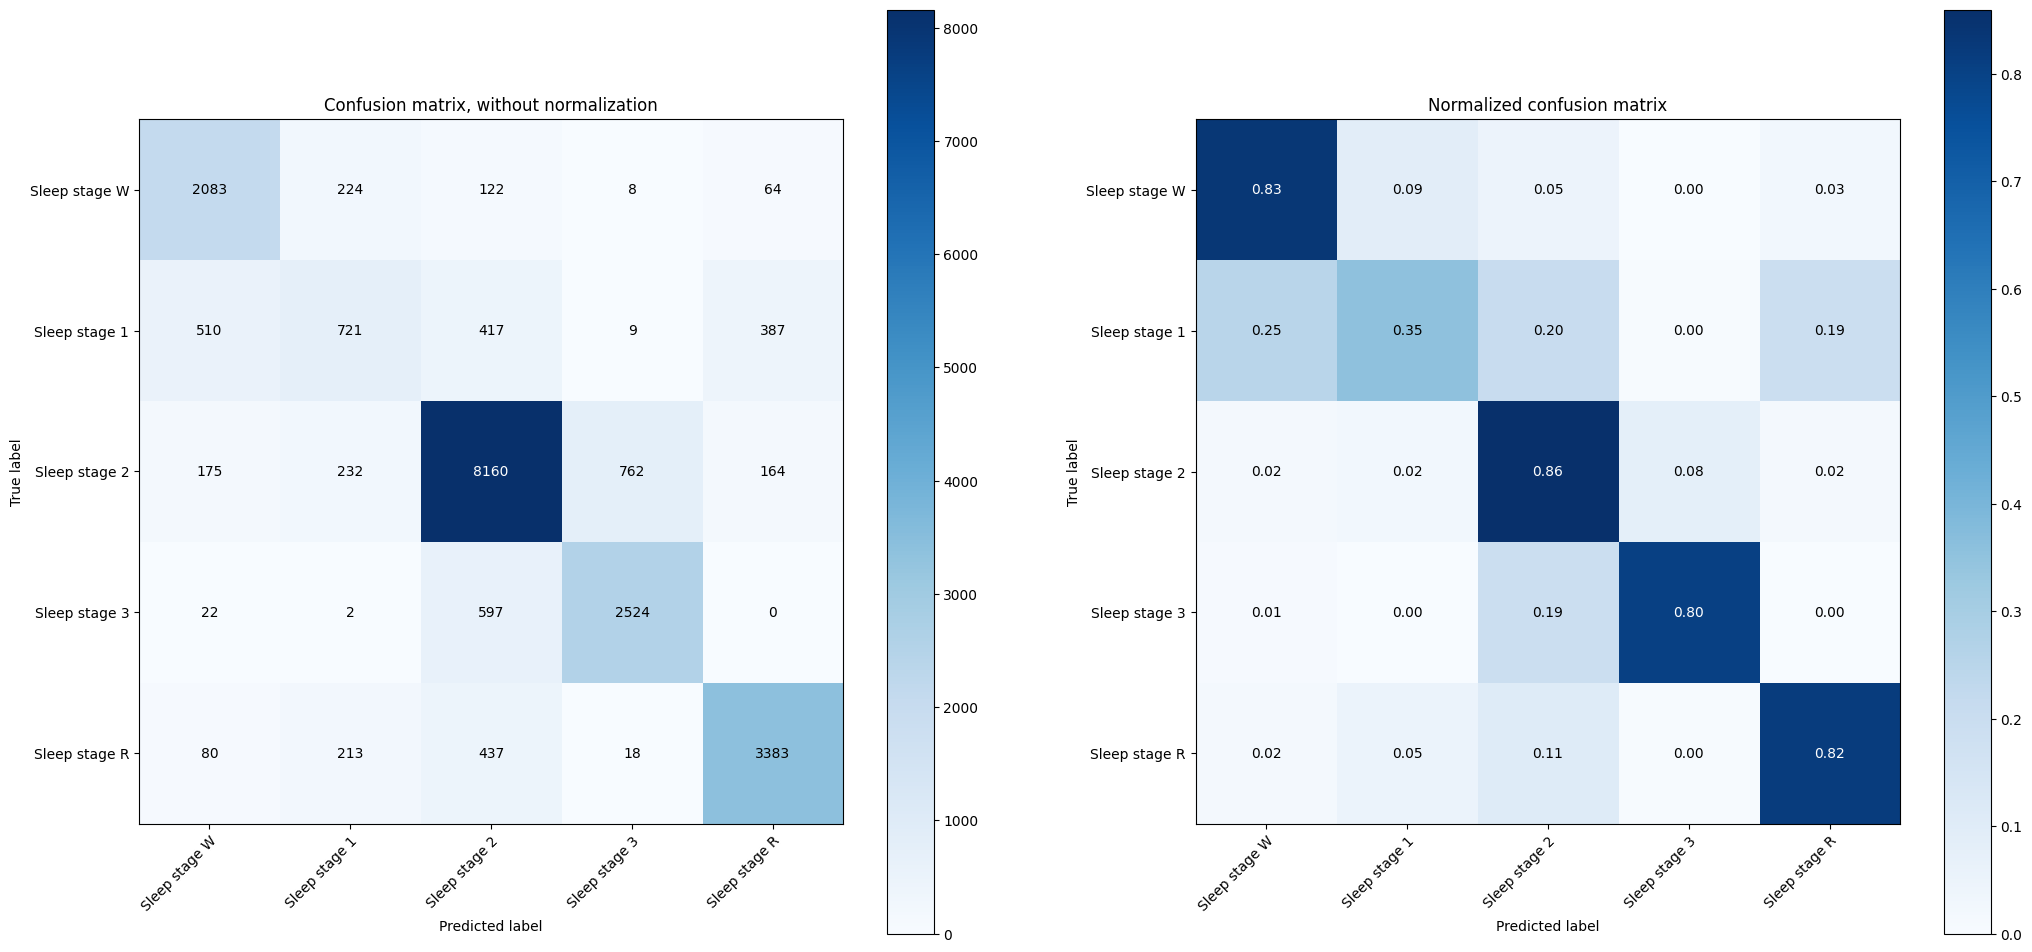

In [73]:
df_telemetry_temazepam_feats = df_telemetry_feats[~df_telemetry_feats.psg_file.isin(df_temazepam_patients.psg_file.unique())]

missing_cols = [col for col in feat_cols if col not in df_telemetry_temazepam_feats.columns]
if missing_cols:
    feat_cols = [col for col in feat_cols if col in df_telemetry_temazepam_feats.columns]

# Predict on placebo patients
print("Sleep Telemetry for placebo patients:")
preds = pipe.predict(df_telemetry_temazepam_feats[feat_cols])
preds_proba = pipe.predict_proba(df_telemetry_temazepam_feats[feat_cols])
print("Log loss:", log_loss(y_true=df_telemetry_temazepam_feats["label"], y_pred=preds_proba))
print(classification_report(y_true=df_telemetry_temazepam_feats["label"], y_pred=preds))


# Metrics
print("\n\n======================= Metrics =======================")
print("F1 macro: ", f1_score(preds, df_telemetry_temazepam_feats["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_telemetry_temazepam_feats["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_telemetry_temazepam_feats["label"]))
print("Log loss :", log_loss(y_true=df_telemetry_temazepam_feats["label"], y_pred=preds_proba))
print("Acc:      ", accuracy_score(preds, df_telemetry_temazepam_feats["label"]))
print("=======================================================")


# Confusion matrix
classes = ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R']
plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_telemetry_temazepam_feats["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_telemetry_temazepam_feats["label"], classes=classes, normalize=True, ax=ax)